In [9]:
import os, sys
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [10]:
# context manager to suppress stdoutm for annoying long printouts
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [11]:
experiment = 'tf_resnet50'
batch_size = 300

In [12]:
platform = 'paperspace' #@param ['colab', 'paperspace'] {allow-input: true}

if platform == 'jupyter_notebook':
    challenge_data_dir = '../data/algonauts_2023_challenge_data'
    exp_output_dir = f'../data/out/{experiment}'

if platform == 'paperspace':
    challenge_data_dir = '/storage/algonauts_2023_challenge_data'
    exp_output_dir = f'/notebooks/data/out/{experiment}'

## Functions not aligned with the current structuree

In [13]:
def train_pca(model, train_dataset):
    
    features = []
    for batch in train_dataset:
        # Extract features
        with HiddenPrints():
            ft = model.predict(batch)
        # Flatten the features
        ft = ft.reshape(ft.shape[0], -1)
        # Append to list
        features.append(ft)
    # Combine features from all batches
    features = np.vstack(features)
    n_components = 100
    print('Features shape: ', features.shape, ' PCA Components: ', n_components)
    # Fit PCA to combined features
    pca = PCA(n_components=n_components)
    pca.fit(features)
    # print('plot the explained variance')
    # plt.plot(pca.explained_variance_ratio_)
    # plt.show()
    # print('plot the cumulative explained variance')
    # plt.plot(np.cumsum(pca.explained_variance_ratio_))
    # plt.show()
    return pca

def extract_and_transform_features(dataset, model, pca):
    features = []
    for batch in dataset:
        with HiddenPrints():
            ft = model.predict(batch)
        # Flatten the features
        ft = ft.reshape(ft.shape[0], -1)
        # Fit PCA to batch of features
        ft = pca.transform(ft)
        features.append(ft)
    return np.vstack(features)

def load_datasets(dataset, image_size, normalise_dataset):
    train_val_imgs_paths = [os.path.join(dataset.train_img_dir, img_name) for img_name in dataset.training_img_list]
    train_paths = [train_val_imgs_paths[i] for i in dataset.idxs_train]
    val_paths = [train_val_imgs_paths[i] for i in dataset.idxs_val]
    test_imgs_paths = [os.path.join(dataset.test_img_dir, img_name) for img_name in dataset.test_img_list]

    train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
    val_ds = tf.data.Dataset.from_tensor_slices(val_paths)
    test_ds = tf.data.Dataset.from_tensor_slices(test_imgs_paths)

    def load_image(image_path):
        # load image file
        img = tf.io.read_file(image_path)
        # decode image
        img = tf.image.decode_jpeg(img, channels=3)
        # resize image to a fixed shape
        img = tf.image.resize(img, image_size)
        return img
    
    def process(ds):
        ds = ds.map(load_image)
        ds = ds.map(normalise_dataset)
        ds = ds.batch(batch_size)
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds
    
    train_ds = process(train_ds)
    val_ds = process(val_ds)
    test_ds = process(test_ds)

    return train_ds, val_ds, test_ds

def save_predictions(lh_fmri_test_pred, rh_fmri_test_pred, subject_submission_dir):
    lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
    rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

    np.save(os.path.join(subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
    np.save(os.path.join(subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)

## Specify model and appropriate image preprocessing steps
Define a function to load and return the model, printing its layers.
Due to memory constraints, we will delete the model from memory in each loop. Here we first load it, print its
nodes and delete it.

In [14]:
def load_model(layer_name=None):
    # Take models from here https://keras.io/api/applications/
    model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
    # Slice the model to extract features from a specific layer
    if layer_name is not None:
        model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return model

normalise_dataset = tf.keras.applications.vgg16.preprocess_input
image_size = (224, 224)

model = load_model()
print(*(layer.name for layer in model.layers), sep=' -> ')
del model

input_3 -> block1_conv1 -> block1_conv2 -> block1_pool -> block2_conv1 -> block2_conv2 -> block2_pool -> block3_conv1 -> block3_conv2 -> block3_conv3 -> block3_pool -> block4_conv1 -> block4_conv2 -> block4_conv3 -> block4_pool -> block5_conv1 -> block5_conv2 -> block5_conv3 -> block5_pool


## Select layers and subjects
Now let's define which layer(s) we will pick from, and which subject(s) to process

In [15]:
layers = ['block2_pool', 'block1_pool'] 
subjects = [
    1, 
    # 2, 3, 4, 5, 6, 7, 8
    ]


## Run pipeline

Running for layer block2_pool
Running for subject 1
Training images: 9841
Test images: 159
LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Training images: 9841
Test images: 159
Training stimulus images: 8856

Validation stimulus images: 985

Test stimulus images: 159
Loading datasets...
Datasets loaded
Training PCA...
Features shape:  (8856, 401408)  PCA Components:  100
PCA over
Extracting and transforming features...
Features extracted and transformed
Fitting regression...
Regression fitted
Predicting fMRI data...
fMRI data predicted
Calculating correlations...


100%|██████████| 20544/20544 [00:01<00:00, 20338.97it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Correlations calculated
output dir:  /notebooks/data/out/tf_resnet50
Layer: block2_pool Subject: 1

LH Correlation: 0.2881579703432341 RH Correlation: 0.28386458263395276



LH median roi correlation: ['V1v: 0.5897957051233584', 'V1d: 0.5970902112175049', 'V2v: 0.5041234381651888', 'V2d: 0.4903888246603888', 'V3v: 0.4838961787950231', 'V3d: 0.47075146602111284', 'hV4: 0.3725546929661441', 'EBA: 0.2672601317202877', 'FBA-1: 0.23740933830939606', 'FBA-2: nan', 'mTL-bodies: nan', 'OFA: 0.3374099443042491', 'FFA-1: 0.29363854568575765', 'FFA-2: nan', 'mTL-faces: nan', 'aTL-faces: nan', 'OPA: 0.31080786007934086', 'PPA: 0.3000444728801699', 'RSC: 0.40249601804654933', 'OWFA: 0.3596165585651912', 'VWFA-1: 0.1908512324101088', 'VWFA-2: 0.15959075874408765', 'mfs-words: 0.15715202126541458', 'mTL-words: nan', 'early: 0.46732386247099955', 'midventral: 0.3886691467590211', 'midlateral: 0.31711428365147004', 'midparietal: 0.33870794264544024', 'ventral: 0.2348244948475931', 'lateral: 0.261786329

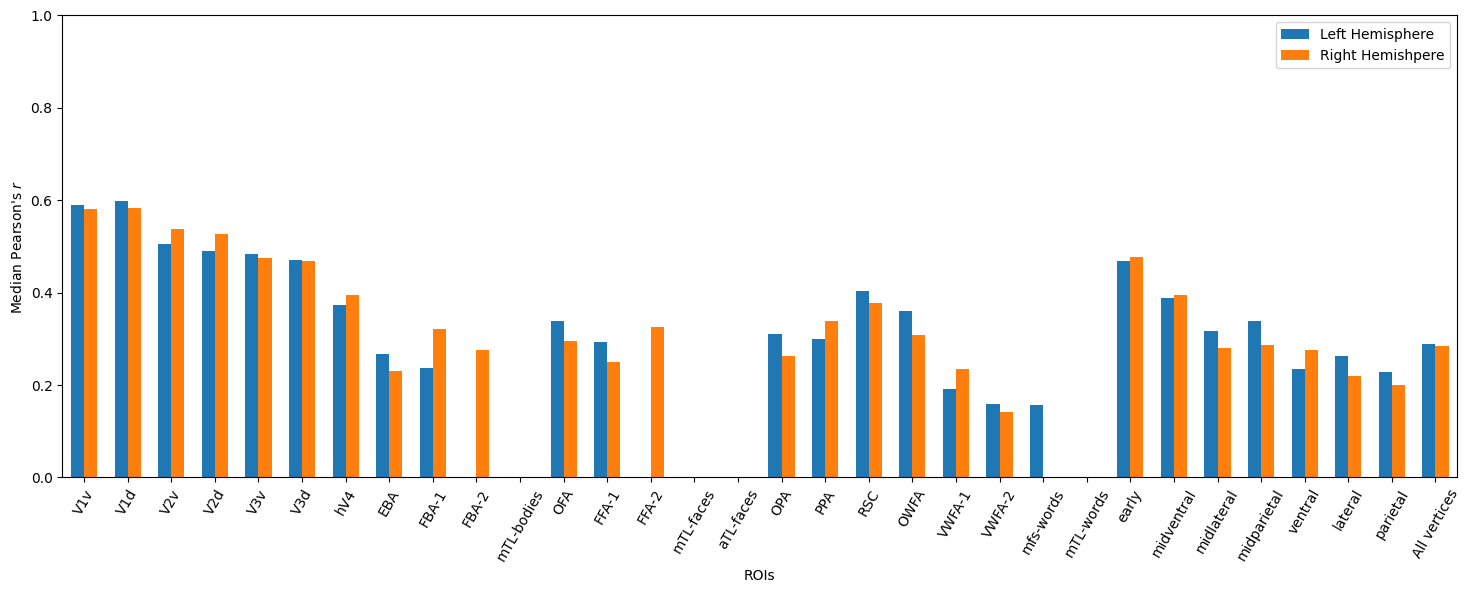

Running for layer block1_pool
Running for subject 1
Training images: 9841
Test images: 159
LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Training images: 9841
Test images: 159
Training stimulus images: 8856

Validation stimulus images: 985

Test stimulus images: 159
Loading datasets...
Datasets loaded
Training PCA...


In [16]:
from src.algonauts.evaluators import correlations as corr
from src.algonauts.data_processors.nsd_dataset import NSDDataset

for layer_name in layers:
    print(f'Running for layer {layer_name}')
    for subj in subjects:
        print(f'Running for subject {subj}')

        # Set data directories based on parameters
        output_dir = f'{exp_output_dir}/{layer_name}'
        dataset = NSDDataset(challenge_data_dir, output_dir, subj)

        print('Loading datasets...')
        train_ds, val_ds, test_ds = load_datasets(dataset, image_size, normalise_dataset)
        print('Datasets loaded')

        # Load model for the iteration
        model = load_model(layer_name)
        
        # Train PCA
        print('Training PCA...')
        pca = train_pca(model, train_ds)
        print('PCA over')

        # Extract and transform features
        print('Extracting and transforming features...')
        train_features = extract_and_transform_features(train_ds, model, pca)
        val_features = extract_and_transform_features(val_ds, model, pca)
        test_features = extract_and_transform_features(test_ds, model, pca)
        print('Features extracted and transformed')

        # Delete model to free up memory
        del model, pca

        # Fit regression
        print('Fitting regression...')
        reg_lh = LinearRegression().fit(train_features, dataset.lh_fmri_train)
        reg_rh = LinearRegression().fit(train_features, dataset.rh_fmri_train)
        print('Regression fitted')
        
        # Use fitted linear regressions to predict the validation and test fMRI data
        print('Predicting fMRI data...')
        lh_fmri_val_pred = reg_lh.predict(val_features)
        lh_fmri_test_pred = reg_lh.predict(test_features)
        rh_fmri_val_pred = reg_rh.predict(val_features)
        rh_fmri_test_pred = reg_rh.predict(test_features)
        print('fMRI data predicted')
        # Calculate correlations for each hemispher
        print('Calculating correlations...')
        lh_correlation = corr.calculate_correlation(lh_fmri_val_pred, dataset.lh_fmri_val)
        rh_correlation = corr.calculate_correlation(rh_fmri_val_pred, dataset.rh_fmri_val)  
        print('Correlations calculated')
    
        corr.plot_and_write_correlations(dataset, lh_correlation, rh_correlation, exp_output_dir, layer_name, subj)
        # Save test predictions
        np.save(os.path.join(dataset.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
        np.save(os.path.join(dataset.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)